In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import LinearNDInterpolator

In [2]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200


plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"
})

In [3]:
masses = [
    8, 9, 10, 11, 12, 13, 14, 15
] # Msun
mass_range = np.linspace(np.min(masses), np.max(masses), int(1e4))

couplings = [ -10, -9, -8 ]

age_range = np.linspace(0, 50, 100) # in Mya

colormap_m = plt.cm.ScalarMappable( 
    colors.Normalize(np.min(masses), np.max(masses)),
    plt.get_cmap(f'winter')
)

colormap_g = plt.cm.ScalarMappable( 
    colors.Normalize(np.min(couplings), np.max(couplings)),
    plt.get_cmap(f'winter')
)

colormap_age = plt.cm.ScalarMappable( 
    colors.Normalize(np.min(age_range), np.max(age_range)),
    plt.get_cmap(f'winter')
)

isotopes = [
    'c12', 
    'o16', 
    'ne20', 
    'na23',
]


labels = list(({
    # 'model': 'slice',
    'm': 'mass (Msun)',
    # 'coupling': 'coupling',
    'age': 'age (years)',
    # 'til': 'time to core O depletion (years)',
    # 'dt': 'dt (years)',
    
    # 'm_enc': 'mass enclosed (Msun)',
    # 'dm': 'dm (g)',
    # 'r': 'r (Rsun)',
    # 'dr': 'dr (cm)',
    # 'T': 'T (K)',
    # 'T_core': 'core T (K)',
    'T_eff': 'effective T (K)',
    # 'log_T': 'log T',
    
    # 'eps_grav': 'eps_grav (ergs/g s)',
    # 'eps_nuc': 'eps_nuc (ergs/g s)', 
    # 'eps_non_nuc_neu': 'eps_neu (ergs/g s)',
    # 'eps_a': 'eps_a (ergs/g s)',
    
    # 'lum_gamma': 'lum_gamma (ergs/s)',
    # 'lum_neu': 'lum_neu (ergs/s)',
    # 'lum_a': 'lum_a (ergs/s)',
    
    'lum_gamma_surf': 'surface lum_gamma (ergs/s)',
    # 'lum_neu_surf': 'surface lum_neu (ergs/s)',
    # 'lum_a_surf': 'surface lum_a (ergs/s)',
    
    # 'cum_e_gamma': 'cumulative e_gamma (ergs)',
    # 'cum_e_neu': 'cumulative e_neu (ergs)',
    # 'cum_e_a': 'cumulative e_a (ergs)',
}).values())

lumSun = 3.846e33 # ergs/s

# crank this up for full thing
max_slices = 10000

In [4]:
datatable = dict()

for g in couplings:
    data = list()
    for m in masses:
        try:
            key = f'm{m:04.1f}_g{g:+04.2f}'
            run = pd.read_csv(f'csv/{key}/index.csv')
            run['mass (Msun)'] = float(key[1:5])
            data.append(run[labels].to_numpy()[:max_slices])
            print(key, end=',\t')
        except FileNotFoundError as e:
            print(e)
    if len(data):
        datatable[g] = np.concatenate(data)

m08.0_g-10.00,	m09.0_g-10.00,	m10.0_g-10.00,	m11.0_g-10.00,	m12.0_g-10.00,	m13.0_g-10.00,	m14.0_g-10.00,	m15.0_g-10.00,	m08.0_g-9.00,	m09.0_g-9.00,	[Errno 2] No such file or directory: 'csv/m10.0_g-9.00/index.csv'
m11.0_g-9.00,	m12.0_g-9.00,	m13.0_g-9.00,	m14.0_g-9.00,	m15.0_g-9.00,	m08.0_g-8.00,	m09.0_g-8.00,	m10.0_g-8.00,	m11.0_g-8.00,	[Errno 2] No such file or directory: 'csv/m12.0_g-8.00/index.csv'
m13.0_g-8.00,	[Errno 2] No such file or directory: 'csv/m14.0_g-8.00/index.csv'
[Errno 2] No such file or directory: 'csv/m15.0_g-8.00/index.csv'


In [5]:
# our interpolation grid is indexed by mass, coupling, age
label_points = labels[:2]
label_values = labels[2:]
label_points, label_values

(['mass (Msun)', 'age (years)'],
 ['effective T (K)', 'surface lum_gamma (ergs/s)'])

In [6]:
#interpolate in-between masses and ages
interps = dict()

for g in datatable:
    print(g)
    data = datatable[g]
    grid_points = data[:, :2]
    grid_values = data[:, 2:]
    interps[g] = LinearNDInterpolator(grid_points, grid_values)

-10
-9
-8


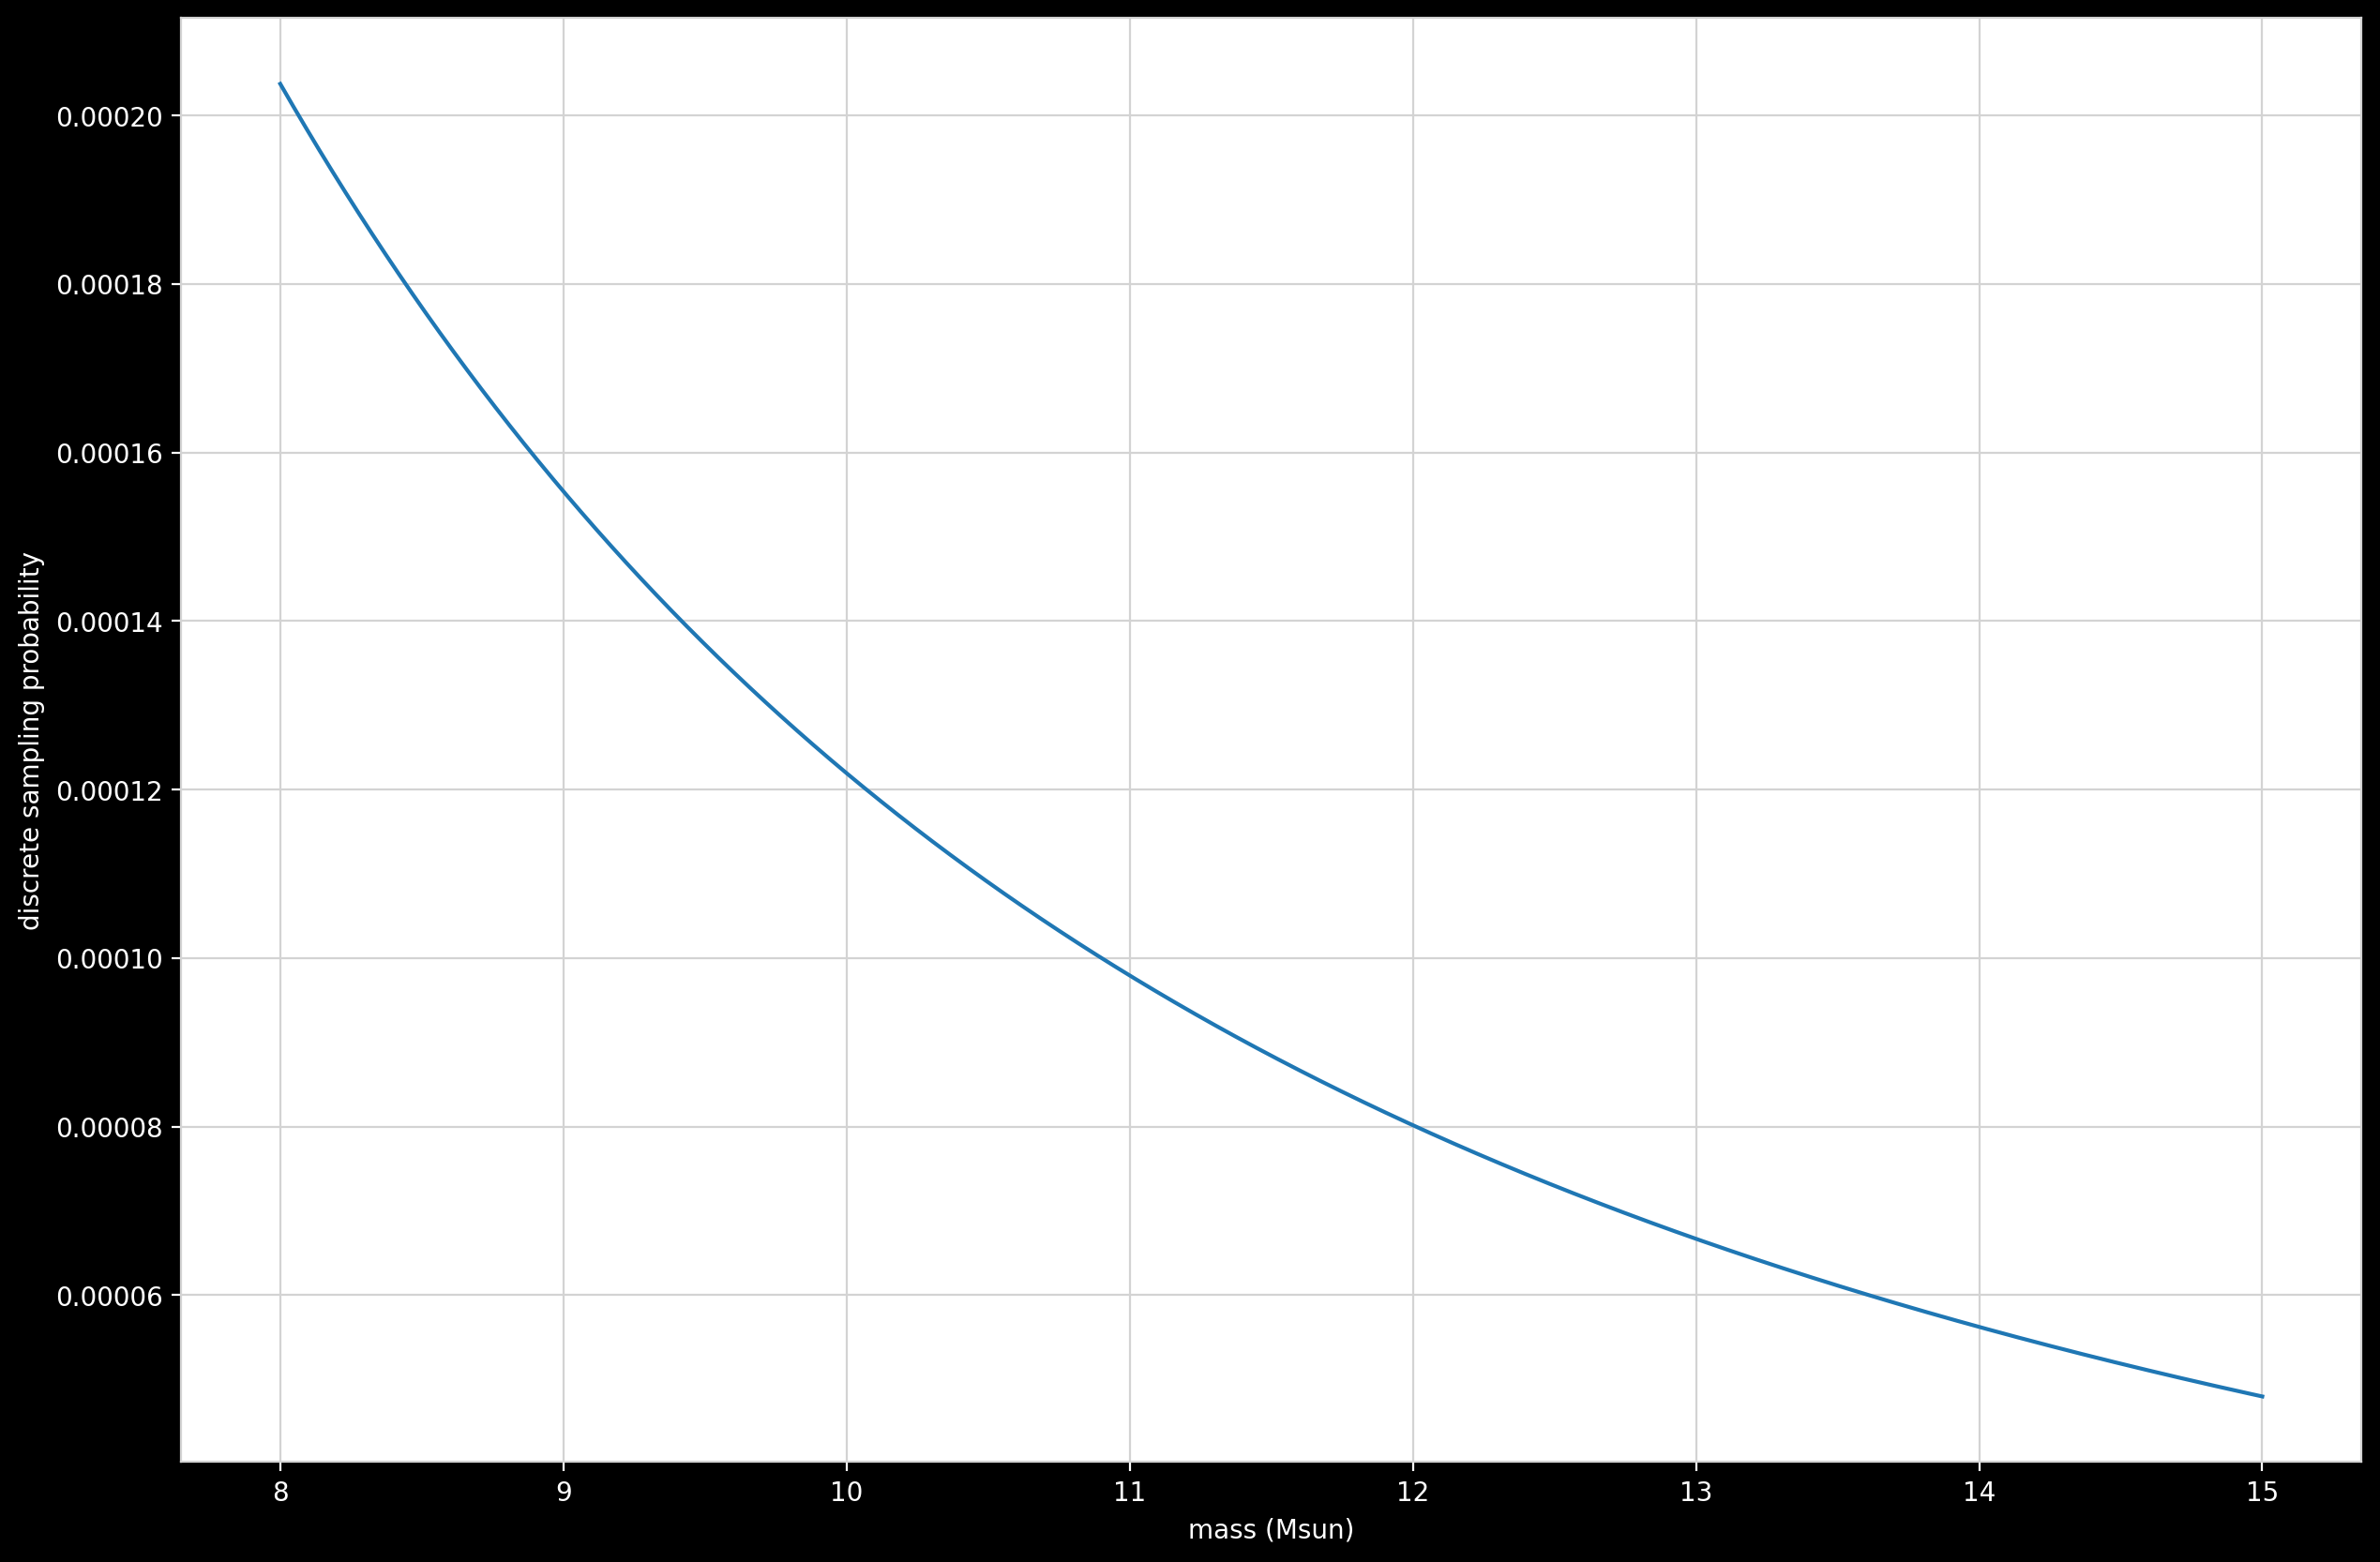

In [7]:
# inverse of initial mass function
imf = lambda m: m**(-2.3)
pdf = imf(mass_range)
pdf /= np.sum(pdf)
plt.plot(mass_range, pdf)
plt.grid()
plt.xlabel('mass (Msun)')
plt.ylabel('discrete sampling probability')
plt.show()

In [8]:
def hr(age, g, N_samples):
    m = np.random.choice(mass_range, size=N_samples, p=pdf)
    t = np.random.normal(age, 1e6)
    values = interps[g](m, t)
    return values.T

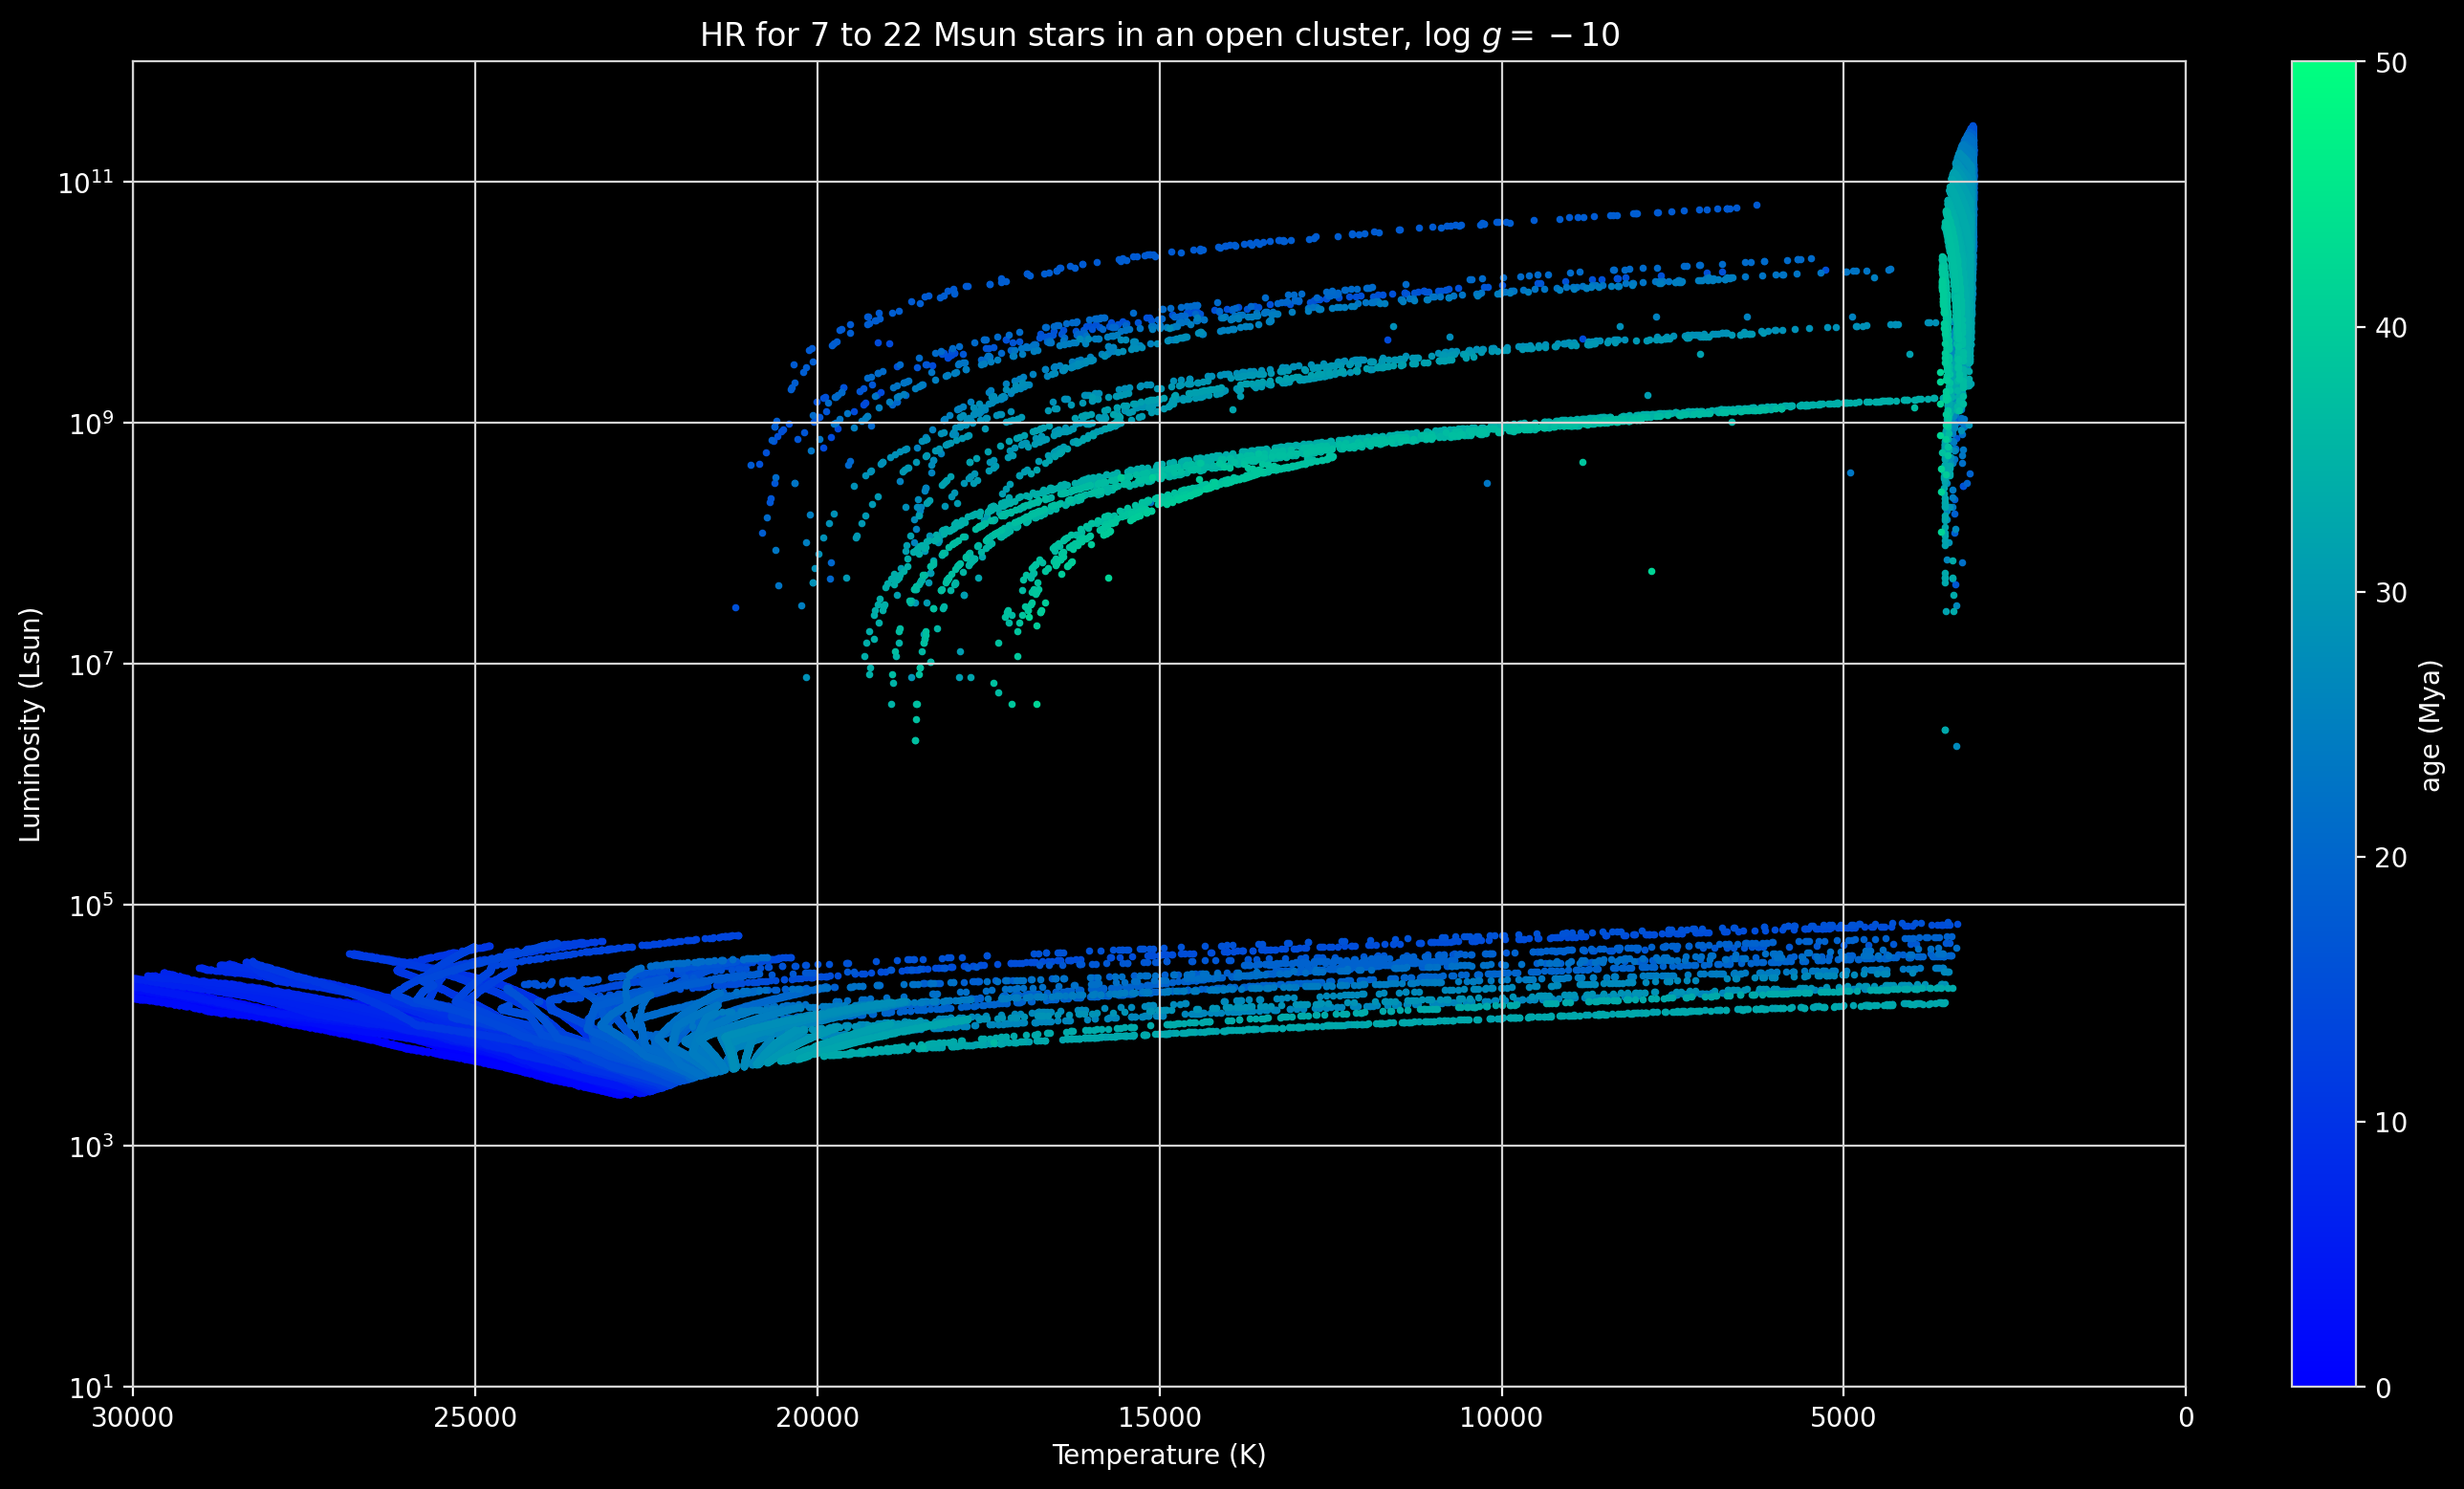

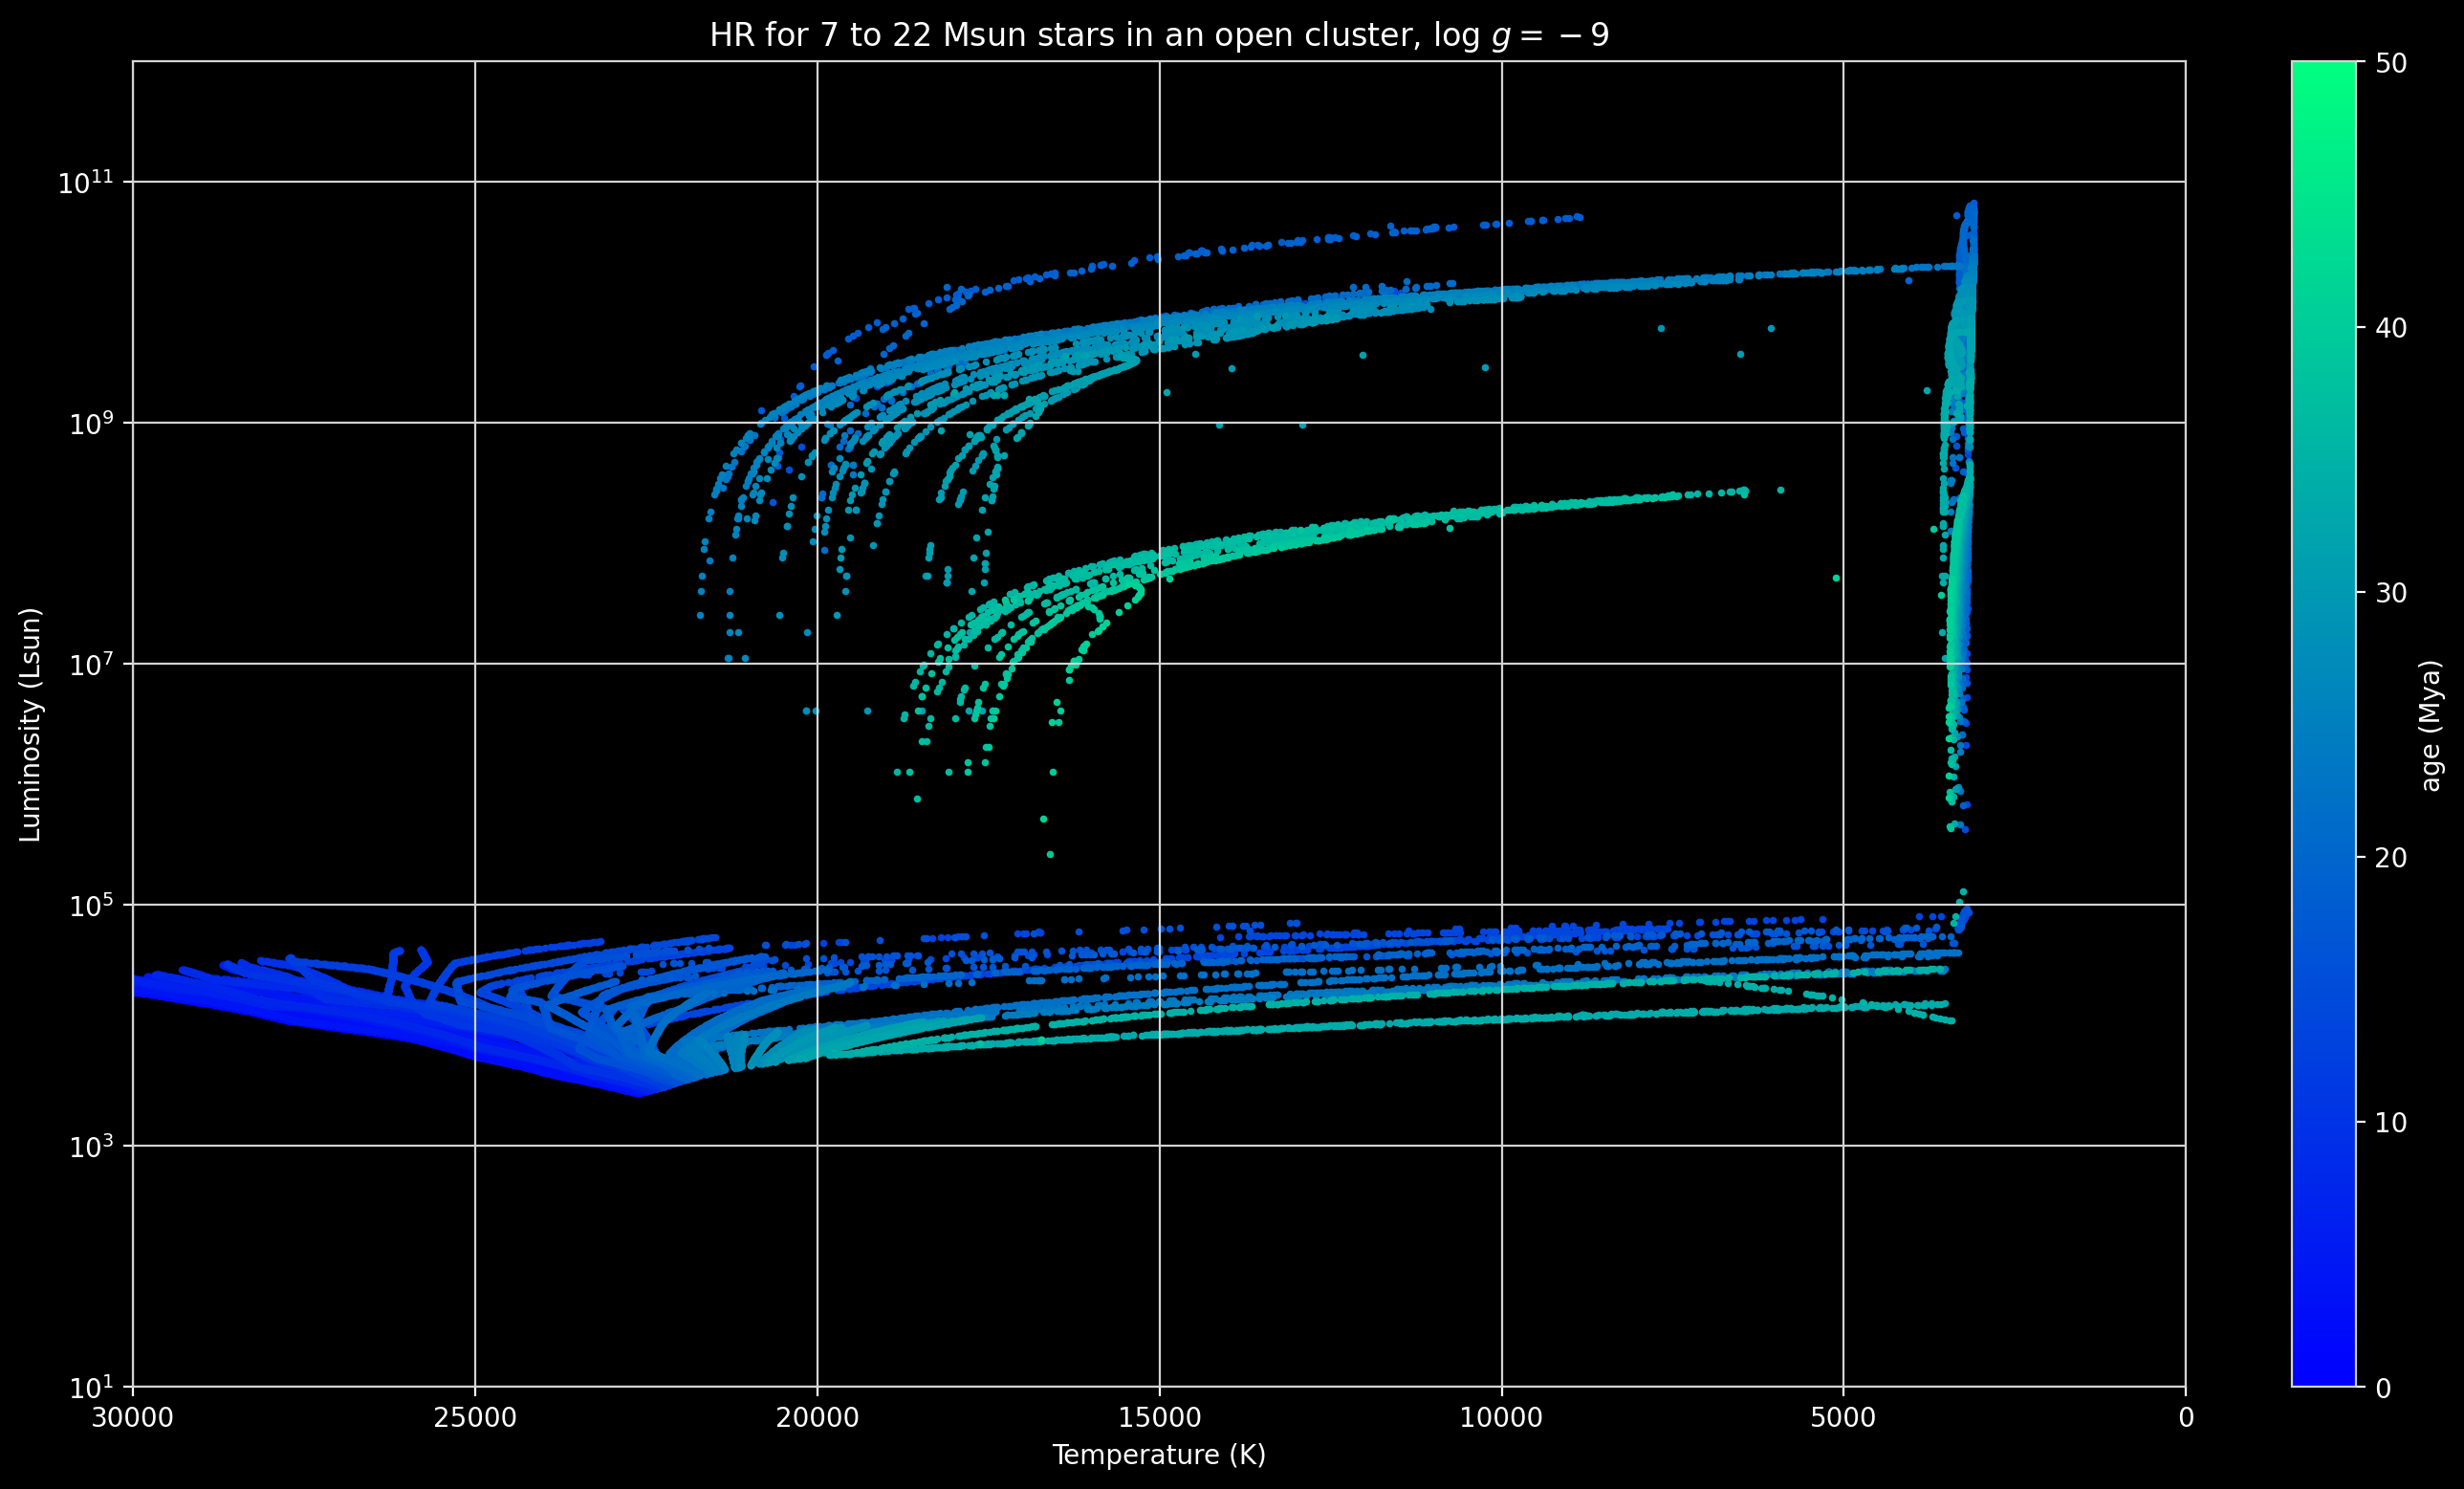

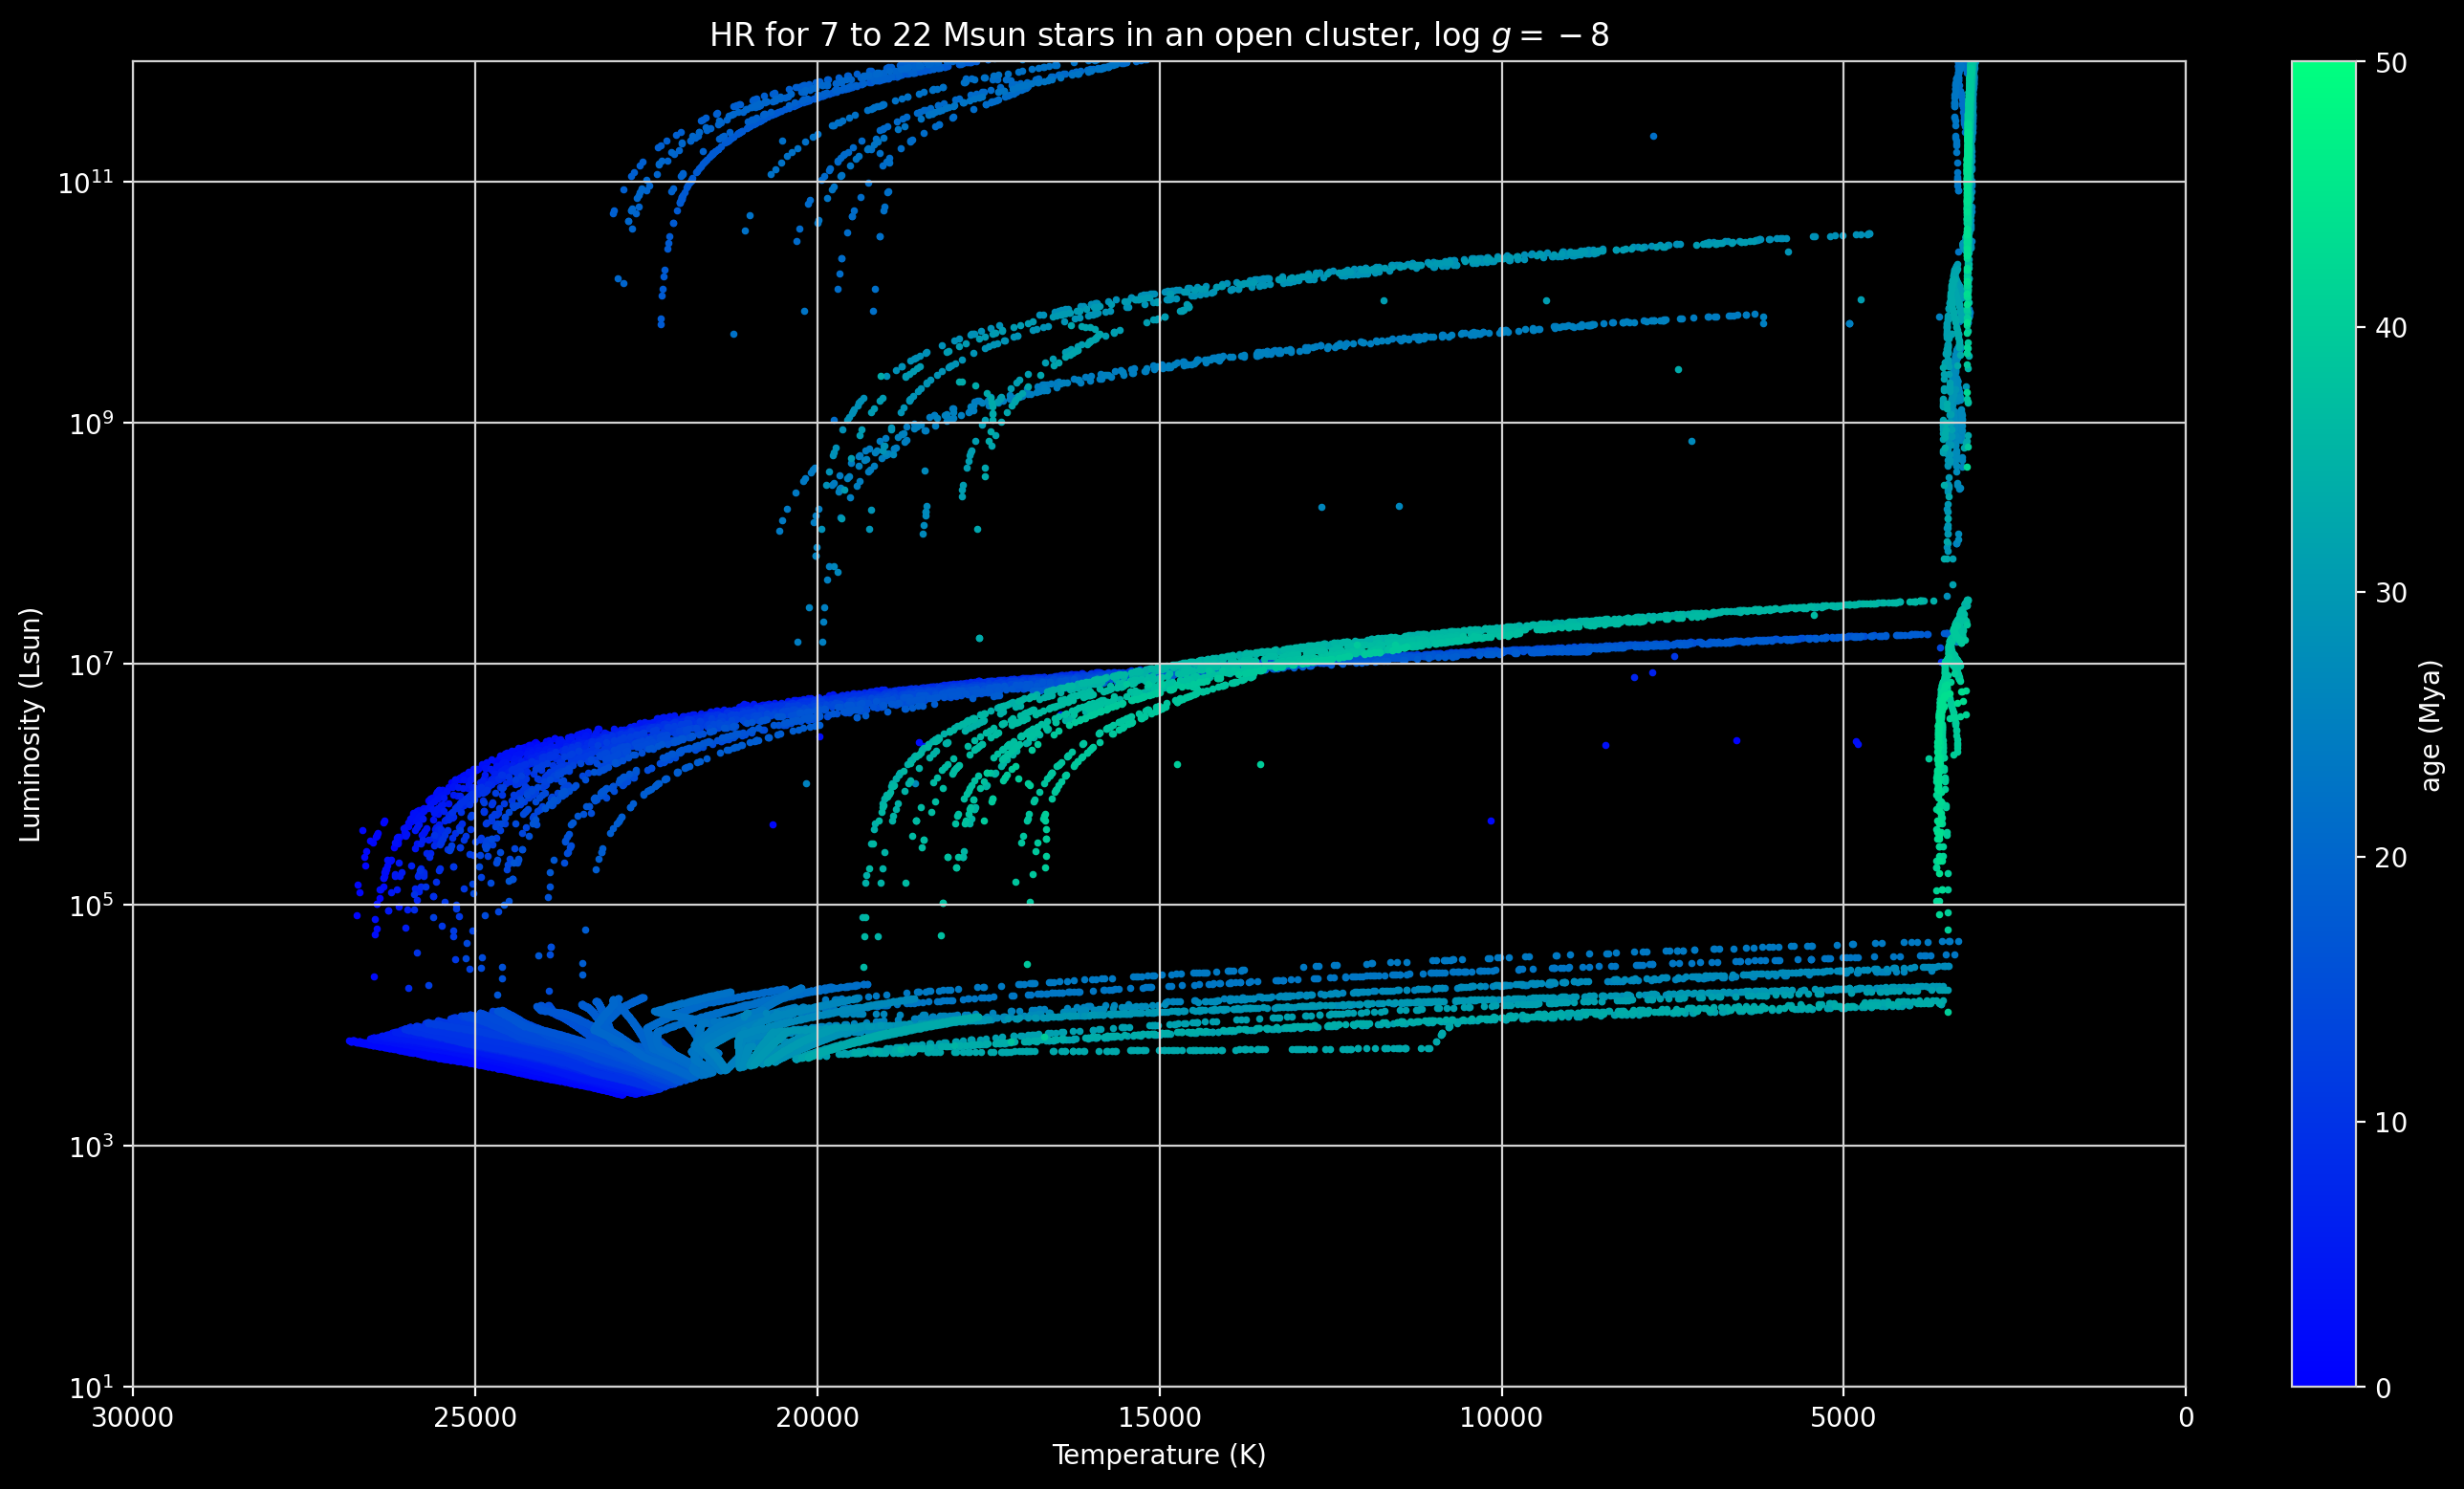

In [9]:
for g in couplings:
    fig, (main_ax, color_ax) = plt.subplots(ncols=2, figsize=(15, 9), 
                                            gridspec_kw={'width_ratios': [32, 1], 'wspace': 0.1 }
                                           )
    main_ax.set_facecolor('black')
    fig.colorbar(colormap_age, label='age (Mya)', cax=color_ax)
    plt.sca(main_ax)
    main_ax.set_yscale('log')
    
    for age in age_range:
        (T, lum) = hr(age*1e6, g, int(1e3))
        lum /= lumSun
        plt.scatter(T, lum, s=3, color=colormap_age.to_rgba(age))
    plt.grid()
    
    plt.ylabel('Luminosity (Lsun)')
    plt.xlabel('Temperature (K)')
    plt.xlim(3e4, 0)
    plt.ylim(1e1, 1e12)
    plt.title(f'HR for 7 to 22 Msun stars in an open cluster, log $g = {g}$', color='white')
    
    plt.show()

/tmp/ipykernel_33804/390054318.py:26: RuntimeWarning: invalid value encountered in divide
  plt.plot(age_range, HB/(HB + MS), label=f'$g={g}$')
/tmp/ipykernel_33804/390054318.py:26: RuntimeWarning: invalid value encountered in divide
  plt.plot(age_range, HB/(HB + MS), label=f'$g={g}$')
/tmp/ipykernel_33804/390054318.py:26: RuntimeWarning: invalid value encountered in divide
  plt.plot(age_range, HB/(HB + MS), label=f'$g={g}$')


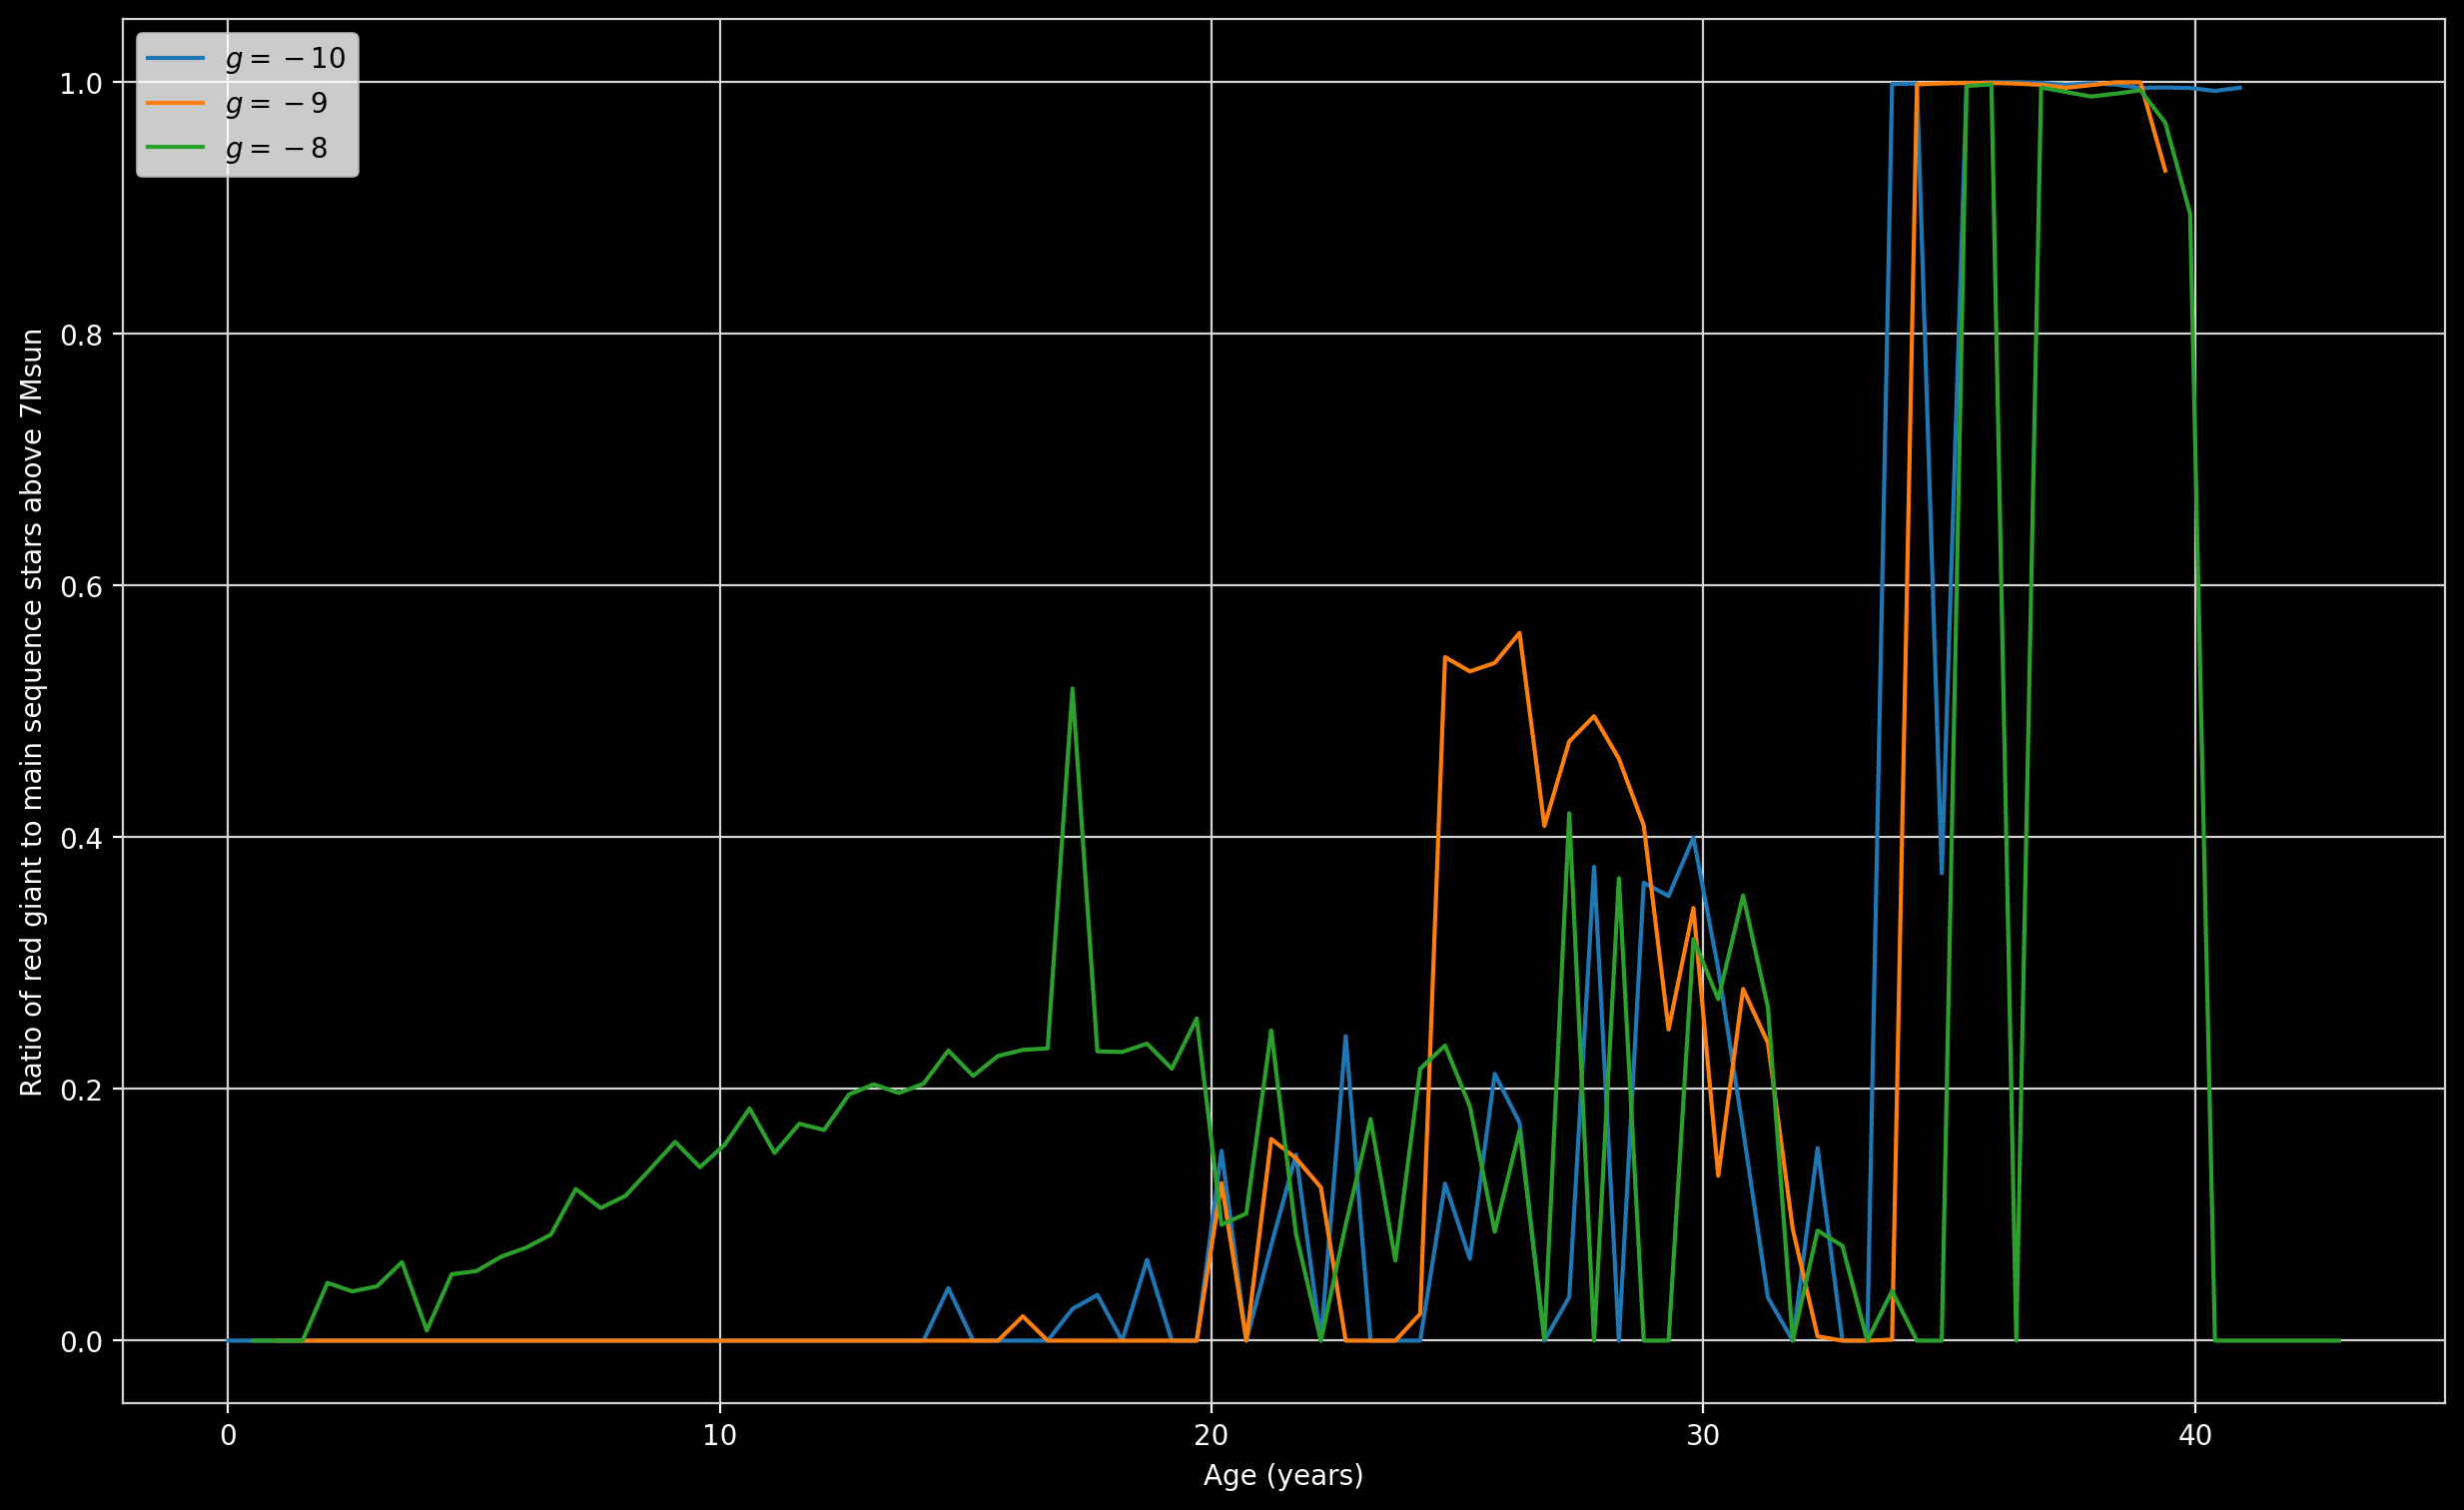

In [13]:
fig, main_ax = plt.subplots(ncols=1, figsize=(15, 9),)
main_ax.set_facecolor('black')
plt.sca(main_ax)

for g in couplings:
    HB = []
    MS = []
    RGB = []

    for age in age_range:
        (T, lum) = hr(age*1e6, g, int(1e4))
        
        HB_select = np.logical_and(T > 5000, lum > 2e6 * lumSun)
        HB.append(T[HB_select].size)

        MS_select = np.logical_and(lum > 1e3 * lumSun, lum < 1e5 * lumSun)
        MS.append(T[MS_select].size)

        RGB_select = np.logical_and(T < 5000, lum > 1e5 * lumSun)
        RGB.append(T[RGB_select].size)
    
    HB = np.array(HB)
    MS = np.array(MS)
    RGB = np.array(RGB)
    
    plt.plot(age_range, HB/(HB + MS), label=f'$g={g}$')
    
plt.grid()
plt.legend()

# plt.title(f' log $g = {g}$', color='white')
plt.xlabel('Age (years)')
plt.ylabel('Ratio of red giant to main sequence stars above 7Msun')
plt.show()